In [1]:
import csv
import sklearn
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
from tensorflow.keras.utils import (
    Sequence,
)  # needed if more than one feature is fed into model

import os, sys


# Set up the Project Path
# Add this line to your ~/.bashrc or ~/.zshrc: export REALTIMEID_PATH='/absolute/path/to/project'
project_path = os.environ.get('MLSTOCKS_PATH')
if project_path and project_path not in sys.path:
    sys.path.append(project_path)
    print("Project path successfully added.")
else:
    print("Warning: 'MLSTOCKS_PATH' environment variable is not set.")


from src.preprocess.preprocess import StockPricePreprocessor
from src.stock_sequence.stock_sequence import StockSequence
from src.sequence_model.sequence_model import SequenceModel

2024-01-01 19:29:01.208059: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/julianthoenniss/Documents/fML/ML-StockAnalysis/.venv/lib/python3.8/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Project path successfully added.


In [2]:
# Download using yfinance
nasdaq_100 = yf.download(tickers="qqq", period="max", interval="1d")
google = yf.download(tickers="GOOGL", period="max", interval="1d")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [3]:
#Extract data arrays from panda frames

google_close = google["Close"].values
google_vols = google["Volume"].values
nasdaq_100_close = nasdaq_100["Close"][-len(google_close) :].values

assert len(google_close) == len(google_vols) and len(google_close) == len(nasdaq_100_close), "Lenghts of data arrays not compatible."

In [4]:
#preprocess data
preprocessor = StockPricePreprocessor()

google_close_training_scaled, google_close_test_scaled = preprocessor.pre_process_maxmin(prices=google_close, feature_name="google_close")
google_vols_training_scaled, google_vols_test_scaled = preprocessor.pre_process_maxmin(prices=google_vols, feature_name="google_vols")
nasdaq_100_training_scaled, nasdaq_100_test_scaled = preprocessor.pre_process_maxmin(prices=nasdaq_100_close, feature_name="nasdaq_100_close")


In [5]:
#prepare training data
sequence_length = 30  # Length of input sequences
batch_size = 32

# Generate input sequences
training_data = StockSequence(
    google_close_training_scaled, google_vols_training_scaled, nasdaq_100_training_scaled, batch_size, sequence_length
)

In [6]:
#build the model with parameters adapted to training data
model = SequenceModel(training_data=training_data).compile_model()

#train the model
model.fit(epochs=10, batch_size=32)

Epoch 1/10
121/121 [==============================] - 5s 15ms/step - loss: 0.0084
Epoch 2/10
121/121 [==============================] - 2s 14ms/step - loss: 2.6923e-04
Epoch 3/10
121/121 [==============================] - 2s 13ms/step - loss: 2.3143e-04
Epoch 4/10
121/121 [==============================] - 2s 13ms/step - loss: 2.4898e-04
Epoch 5/10
121/121 [==============================] - 1s 12ms/step - loss: 2.4039e-04
Epoch 6/10
121/121 [==============================] - 2s 12ms/step - loss: 1.9961e-04
Epoch 7/10
121/121 [==============================] - 1s 12ms/step - loss: 2.0303e-04
Epoch 8/10
121/121 [==============================] - 2s 12ms/step - loss: 1.9786e-04
Epoch 9/10
121/121 [==============================] - 1s 12ms/step - loss: 1.9225e-04
Epoch 10/10
121/121 [==============================] - 2s 13ms/step - loss: 1.7241e-04


In [7]:
# Perform predictions
# Generate input sequences
test_data_scaled = StockSequence(
    google_close_test_scaled, google_vols_test_scaled, nasdaq_100_test_scaled, batch_size, sequence_length
)

predictions_raw = model.predict(input_data = test_data_scaled).reshape(-1, 1)

# Rescaling the predictions back to their original scale
predictions = preprocessor.inverse_transform(scaled_data = predictions_raw, feature_name="google_close").ravel()

#extract actual histrorical data to compare to
test_targets = google_close[preprocessor.split_index + sequence_length:]


assert len(test_targets) == len(predictions), f"Predictions and actual data have different length:, {len(predictions), len(test_targets)}" 





30/30 [==============================] - 0s 5ms/step


In [8]:
#compute error measures

mse = np.mean((test_targets - predictions) ** 2)#mean squared error
rmse = np.sqrt(mse)#root mean squared error
mae = np.mean(np.abs(test_targets - predictions))#mean absolute error

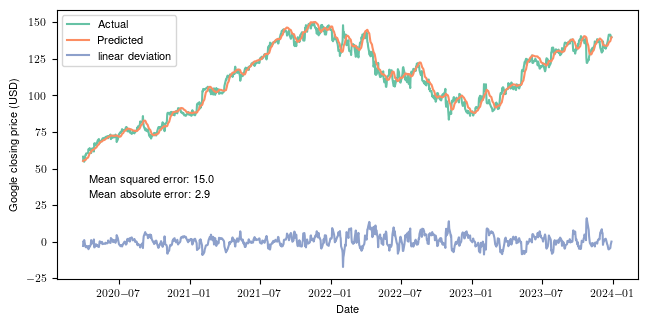

In [9]:
# Visualize the results

#Set global plot parameters
plt.rcParams.update({"text.usetex": True, "font.family": "Helvetica", "font.size": 8})

fig, axs = plt.subplots(1, 1, figsize=(7.5, 3.5))
cmap_set1 = plt.get_cmap("Set2")
cmap_set2 = plt.get_cmap("Reds")


dates_array = google.index.to_numpy()[-len(predictions):]
axs.plot(dates_array, test_targets, color=cmap_set1(0), label="Actual")
axs.plot(dates_array,predictions, color=cmap_set1(1), label="Predicted")
axs.plot(dates_array,(predictions-test_targets),color=cmap_set1(2), label="linear deviation")
axs.legend()

axs.set_xlabel("Date")
axs.set_ylabel("Google closing price (USD)")
axs.text(dates_array[10],40,f"Mean squared error: {np.round(mse,1)}")
axs.text(dates_array[10],30,f"Mean absolute error: {np.round(mae,1)}")

plt.savefig(f"../plots/google_close_seq_length={sequence_length}.pdf", bbox_inches='tight')